Data focused considerations:

- Who created the dataset?
- How was the dataset created?
- What transformations were used?
- What intent does the dataset have?
- Possible unintentional consequences?
- Is the dataset biased?
- Are there ethical issues with the dataset?

## prepare data
### ETL (Extract, Transform and Load)

## Loading

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
batch_size = 16

In [2]:
train_set = torchvision.datasets.FashionMNIST(
    root='data/FashionMNIST',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

type(train_set)

torchvision.datasets.mnist.FashionMNIST

In [3]:
train_loader=torch.utils.data.DataLoader(train_set, batch_size=batch_size)

In [4]:
type(train_loader)

torch.utils.data.dataloader.DataLoader

In [5]:
test_set = torchvision.datasets.FashionMNIST(
    root='data/FashionMNIST',
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

test_loader=torch.utils.data.DataLoader(test_set, batch_size=batch_size)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
torch.set_printoptions(linewidth=120)

## See Data

In [8]:
train_set.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [7]:
train_set.targets.bincount() 
# number of samples in each bin/category

tensor([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

In [10]:
train_set.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [11]:
sample = next(iter(train_set))

In [12]:
len(sample) , type(sample)

(2, tuple)

In [13]:
image, label = sample
#sequence / list unpacking

In [14]:
image.shape , label

(torch.Size([1, 28, 28]), 9)

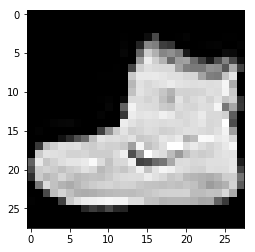

In [15]:
plt.imshow(image.squeeze(), cmap='gray')

In [16]:
batch = next(iter(train_loader))

In [17]:
len(batch) , type(batch)

(2, list)

In [18]:
images, labels = batch
len(images) , len(labels)

(4, 4)

In [19]:
images.shape , labels.shape

(torch.Size([4, 1, 28, 28]), torch.Size([4]))

tensor([9, 0, 0, 3])


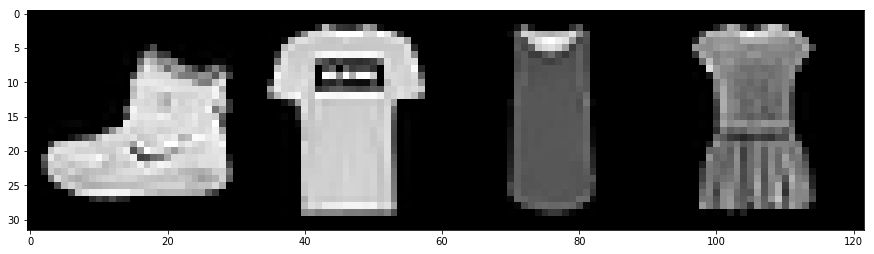

In [20]:
grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)))

print(labels)

## Neural Net

In [7]:
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6 , out_channels=12 , kernel_size=5)
                        
        self.fc1 = nn.Linear(in_features=12*4*4,out_features=120)
        self.fc2 = nn.Linear(in_features=120,out_features=60)
        self.out = nn.Linear(in_features=60,out_features=10)
        #dont have to mention softmax, cuz categorical crossentropy 
        #select korlei eita selecet hoye jay
    
    def forward(self, x):
        x = F.max_pool2d( F.relu(self.conv1(x)) , 2)
        x = F.max_pool2d( F.relu(self.conv2(x)) , 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [8]:
network = Network()

In [9]:
network

Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
)

In [24]:
network.conv1.weight.shape

torch.Size([6, 1, 5, 5])

In [25]:
network.conv2.weight.shape

torch.Size([12, 6, 5, 5])

In [26]:
network.fc1.weight.shape

torch.Size([120, 192])

In [27]:
network.fc2.weight.shape

torch.Size([60, 120])

In [28]:
network.out.weight.shape

torch.Size([10, 60])

In [11]:
for name,param in network.named_parameters():
    print(name, '\t\t' , param.shape)

conv1.weight 		 torch.Size([6, 1, 5, 5])
conv1.bias 		 torch.Size([6])
conv2.weight 		 torch.Size([12, 6, 5, 5])
conv2.bias 		 torch.Size([12])
fc1.weight 		 torch.Size([120, 192])
fc1.bias 		 torch.Size([120])
fc2.weight 		 torch.Size([60, 120])
fc2.bias 		 torch.Size([60])
out.weight 		 torch.Size([10, 60])
out.bias 		 torch.Size([10])


In [10]:
import torch.optim as optim

lossFunc = nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters(), lr=0.0001)

In [11]:
num_epochs = 1

In [12]:
# #smaller set
# train_indices = [i for i in range (15000)]
# test_indices = [i for i in range (2500)]
# ss = torch.utils.data.sampler.SubsetRandomSampler
# train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=ss(train_indices))
# test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, sampler=ss(test_indices))

In [13]:
count = 0
loss_list = []
loss2_list = []
iteration_list = []
accuracy_list = []

for epoch in range(num_epochs):

    running_loss = 0.0
    for i, data in enumerate(train_loader):

        inputs, labels = data
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = network(inputs) # Forward propagation
        loss = lossFunc(outputs, labels)# Calculate softmax and ross entropy loss
        loss.backward()# Calculating gradients
        optimizer.step()# Update parameters
        
        count += 1
        
        # TEST LOSS and ACCURACY
        if count%50 == 0:
            with torch.no_grad():
                correct = 0
                total = 0
                # Iterate through test dataset
                for images, labels in test_loader:
                    outputs = network(images)
                    loss2 = lossFunc(outputs, labels)
                    predicted = torch.max(outputs.data, 1)[1]
                    total += len(labels)
                    correct += (predicted == labels).sum().item()

                accuracy = 100 * correct / float(total)

            loss_list.append(loss.item())
            loss2_list.append(loss2.item())
            iteration_list.append(count)
            accuracy_list.append(accuracy)

            if count%200 == 0:
                print('Iteration: {}  Train_Loss: {} Test_Loss: {}  Test_Accuracy: {} %'
                      .format(count,loss.item(),loss2.item(),accuracy))

print('Finished Training')

#abar run dile it will continue training

Iteration: 200  Train_Loss: 1.9931378364562988 Test_Loss: 1.941361427307129  Test_Accuracy: 41.73 %
Iteration: 400  Train_Loss: 1.2301753759384155 Test_Loss: 0.9618013501167297  Test_Accuracy: 59.46 %
Iteration: 600  Train_Loss: 0.9552164077758789 Test_Loss: 0.7957746982574463  Test_Accuracy: 61.14 %
Iteration: 800  Train_Loss: 1.1385164260864258 Test_Loss: 0.7752750515937805  Test_Accuracy: 65.13 %
Iteration: 1000  Train_Loss: 0.8571135997772217 Test_Loss: 0.662676215171814  Test_Accuracy: 66.75 %
Iteration: 1200  Train_Loss: 0.6091117858886719 Test_Loss: 0.7014292478561401  Test_Accuracy: 67.43 %
Iteration: 1400  Train_Loss: 0.7956187725067139 Test_Loss: 0.63979172706604  Test_Accuracy: 69.04 %
Iteration: 1600  Train_Loss: 1.467987298965454 Test_Loss: 0.6546063423156738  Test_Accuracy: 70.07 %
Iteration: 1800  Train_Loss: 1.1074117422103882 Test_Loss: 0.6481424570083618  Test_Accuracy: 70.14 %
Iteration: 2000  Train_Loss: 0.6277478337287903 Test_Loss: 0.599835991859436  Test_Accuracy

**If your training loss is much lower than validation loss then this means the network might be overfitting. Solutions to this are to decrease your network size, or to increase dropout. ... If training loss << validation loss , it is overfitting; if roughly training loss = validation loss , it is underfitting.**

- Underfitting – Validation and training error high
- Overfitting – Validation error is high, training error low
- Good fit – Validation error low, slightly higher than the training error
- Unknown fit - Validation error low, training error 'high'

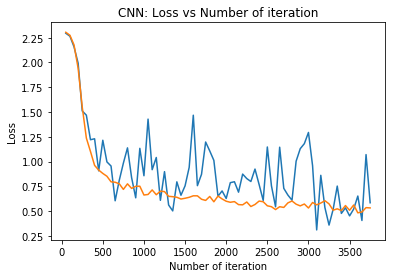

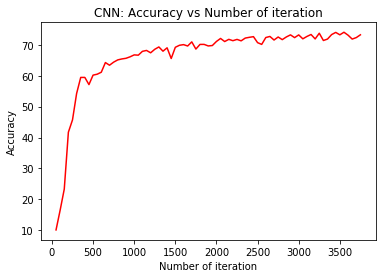

In [14]:
# visualization loss 
plt.plot(iteration_list,loss_list)
plt.plot(iteration_list,loss2_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()